# Read dataset and create data loaders

In [79]:
# Import torch and CIFAR dataset
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F

# Import matplotlib and numpy for graphs
import matplotlib.pyplot as plt
import numpy as np


In [80]:
'''
Import CIFAR dataset, define labbels and load training and validation dataset
Reference for loading dataset: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
Reference for augmentation: https://pytorch.org/vision/stable/transforms.html
'''
batch_size=64 
print('Batch size:', batch_size)

# Normalisation and std values for RGB in dataset
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Data augmentation for training set
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Randomly crop the image with padding
    transforms.RandomHorizontalFlip(),    # Randomly flip the image horizontally
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, etc.
    transforms.RandomRotation(15),        # Randomly rotate the image by up to 15 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Randomly translate the image
    transforms.ToTensor(),                # Convert image to tensor
    transforms.Normalize(mean=mean, std=std),  # Normalize with mean and std
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33))  # Randomly erase a portion of the image (optional)
])

# No augmentation for test set (only normalization)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)  # Normalize with mean and std
])

# Load training and testing datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Define labels
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'lorry')

Batch size: 64
Files already downloaded and verified
Files already downloaded and verified


In [81]:
# # From the PyTorch's tutorial on image classification
# import matplotlib.pyplot as plt
# import numpy as np

# def imshow(img):
#     '''
#     Show an image
#     Input: image file to show
#     Output: image
#     '''
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()

# # Get random training images
# dataiter = iter(trainloader)
# images, labels = next(dataiter)

# # Show images
# imshow(torchvision.utils.make_grid(images))
# # Print labels
# print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Main model
Divided as such:


*   **Stem**: takes the images as inputs, extracts features from them
*   **Backbone**: made up of *K* branches, made up of an expert branch
*   **Classifier**: takes input from the last block
*   **Model**: wraps all together







## Stem
*   Takes images as inputs
*   Extracts a feature representation from them

In [82]:
class Stem(nn.Module):
  '''
  Extract features using a Resnet-18 stem
  Reference: Week 09 Lab
  '''
  def __init__(self, input_channels, middle_channels, output_channels):
     super(Stem,self).__init__()
     # Default parameters
     kernel_size=3
     stride=1
     padding=1
     
     # Combine multiple layers
     self.stem = nn.Sequential(
       nn.Conv2d(input_channels, middle_channels, kernel_size = kernel_size, stride = stride, padding = padding),
       nn.BatchNorm2d(middle_channels), 
       nn.ReLU(inplace=True),
       nn.Conv2d(middle_channels, middle_channels,kernel_size = kernel_size, stride = stride, padding = padding),
       nn.BatchNorm2d(middle_channels),
       nn.ReLU(inplace=True),
       nn.MaxPool2d(2), # Half the size of the image
       nn.Conv2d(middle_channels, output_channels, kernel_size = kernel_size, stride = stride, padding = padding),
       nn.BatchNorm2d(output_channels),
       nn.ReLU(inplace=True),
       nn.MaxPool2d(2) # Half the size of the image
       )

  def forward(self,x):
    x = self.stem(x)
    return x

## Block

In [83]:
class ExpertBranch(nn.Module):
  '''
  Expert branch predicting vector a with K elements from input tensor X
  '''
  def __init__(self, input_channels, k, r):
    super(ExpertBranch,self).__init__()
    # Spatially pool x
    self.pool= nn.AdaptiveAvgPool2d(1)
    #Forward through fc1, reducing by r
    self.fc1= nn.Linear(input_channels, input_channels//r)
    # Activation function ReLu
    self.relu= nn.ReLU()
    # Forward through fc2
    self.fc2= nn.Linear(input_channels//r,k)

  def forward(self,x):
    # Spatially pool X
    x = self.pool(x)
    # Forward through fc1, reducing by r
    x= x.squeeze(-1).squeeze(-1)
    x = self.fc1(x)
    # Processed through non-linear activation g
    x = F.relu(x)
    # Pass through fc2
    x = self.fc2(x)
    # Forward with softmax
    x = F.softmax(x,dim=1)
    return x

In [84]:
class Block(nn.Module):
  '''
  Block
  '''
  def __init__(self, input_channels, output_channels, k, r):
    super(Block, self).__init__()
    # Default parameters
    kernel_size=3
    stride=1
    padding=1
    # Set parameters
    self.k= k
    self.expertBranch = ExpertBranch(input_channels, k=k, r=r)
    # Input from first block
    # Input from previous block for rest
    # Generate vector a with K elements from X as a= E(X)
    # Create K convolutional layers
    self.convs= nn.ModuleList([
        nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, stride= stride, padding=padding)
        for _ in range(k)
    ])

  def forward(self,x):
    identity= x
    # Vector a from expert branch
    a = self.expertBranch(x)
    # Convolutional layers 
    conv_outputs = [conv(x) for conv in self.convs]
    stacked = torch.stack(conv_outputs, dim=1)
    # Create vector O
    a= a.view(a.size(0), self.k, 1,1,1)

    out = (a* stacked).sum(dim=1)
    # Skip connection to stablise gradient descent
    out += identity
    # out = F.relu(out)

    return out

## Backbone

In [85]:
class Backbone(nn.Module):
  '''
  N blocks
  '''
  def __init__(self, input_channels, hidden_channels, num_blocks, k, r):
    super(Backbone, self).__init__()
    self.blocks= nn.ModuleList()

    # First block takes input from stem
    self.blocks.append(Block(input_channels, hidden_channels, k=k, r=r))

    # Rest of blocks take input form previous block
    for _ in range(1, num_blocks):
      self.blocks.append(Block(hidden_channels, hidden_channels, k=k, r=r))

  def forward(self, x):
    for idx, block in enumerate(self.blocks):
      x = block(x)
    return x

## Classifier

In [86]:
class Classifier(nn.Module):
  def __init__(self, input_channels, num_classes, use_mlp):
    super(Classifier,self).__init__()
    # Default parameters
    dropout_rate=0.25
    # Spatially pool
    self.pool = nn.AdaptiveAvgPool2d(1)
    self.use_mlp= use_mlp

    if use_mlp:
      self.classifier= nn.Sequential(
          nn.Linear(input_channels, input_channels*2),
          nn.ReLU(),
          nn.Dropout(dropout_rate), # Deeper network with 3 layers
          nn.Linear(input_channels*2, input_channels),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.Linear(input_channels, num_classes)
      )
    else:
      self.classifier= nn.Linear(input_channels, num_classes)

  def forward(self, x):
    x = self.pool(x).squeeze(-1).squeeze(-1)
    out = self.classifier(x)
    return out


# Model

In [87]:
class Model(nn.Module):
  def __init__(self, input_channels, output_channels, middle_channels, hidden_channels, num_blocks, k, r, num_classes, use_mlp):
    super(Model, self).__init__()
    # Call stem
    self.stem= Stem(
      input_channels=input_channels,
      middle_channels=middle_channels,
      output_channels=output_channels
    )
    # Call backbone
    self.backbone= Backbone(
      input_channels=output_channels, 
      hidden_channels= hidden_channels, 
      num_blocks=num_blocks,
      k=k, 
      r=r)
    # Call classifier
    self.classifier= Classifier(
      input_channels=hidden_channels, 
      num_classes=num_classes,
      use_mlp= use_mlp)

  def forward(self,x):
    x= self.stem(x)
    x= self.backbone(x)
    x= self.classifier(x)
    return x

# Create the loss and optmiser


In [ ]:
model = Model(
    input_channels=3,
    output_channels=128,
    middle_channels=64,
    hidden_channels=128,
    num_blocks=5,
    k=2,
    r=8,
    num_classes=10,
    use_mlp=True
)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.0001, weight_decay=1e-4, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Training & Testing


Epoch 1/25


Train Loss: 1.8907 | Accuracy: 28.16%
Val   Loss: 1.6035 | Accuracy: 38.89%
Saved best model.

Epoch 2/25


Train Loss: 1.6720 | Accuracy: 37.38%
Val   Loss: 1.3759 | Accuracy: 48.12%
Saved best model.

Epoch 3/25


Train Loss: 1.5720 | Accuracy: 42.09%
Val   Loss: 1.2879 | Accuracy: 52.02%
Saved best model.

Epoch 4/25


Train Loss: 1.4982 | Accuracy: 45.14%
Val   Loss: 1.2595 | Accuracy: 53.57%
Saved best model.

Epoch 5/25


Train Loss: 1.4426 | Accuracy: 47.40%
Val   Loss: 1.3310 | Accuracy: 51.42%

Epoch 6/25


Train Loss: 1.3905 | Accuracy: 49.77%
Val   Loss: 1.3630 | Accuracy: 52.65%

Epoch 7/25


Train Loss: 1.3562 | Accuracy: 51.11%
Val   Loss: 1.1898 | Accuracy: 57.77%
Saved best model.

Epoch 8/25


Train Loss: 1.3215 | Accuracy: 52.45%
Val   Loss: 1.0926 | Accuracy: 60.41%
Saved best model.

Epoch 9/25


Train Loss: 1.2996 | Accuracy: 53.29%
Val   Loss: 1.1253 | Accuracy: 60.16%

Epoch 10/25


Train Loss: 1.2771 | Accuracy: 54.33%
Val   Loss: 1.1356 | Accuracy: 59.24%

Epoch 11/25


Train Loss: 1.2464 | Accuracy: 55.11%
Val   Loss: 1.0714 | Accuracy: 61.38%
Saved best model.

Epoch 12/25


Train Loss: 1.2352 | Accuracy: 55.91%
Val   Loss: 1.0355 | Accuracy: 62.39%
Saved best model.

Epoch 13/25


Train Loss: 1.2191 | Accuracy: 56.27%
Val   Loss: 1.0698 | Accuracy: 62.13%

Epoch 14/25


Train Loss: 1.1947 | Accuracy: 57.32%
Val   Loss: 0.9616 | Accuracy: 65.32%
Saved best model.

Epoch 15/25


Train Loss: 1.1789 | Accuracy: 57.90%
Val   Loss: 1.0242 | Accuracy: 63.33%

Epoch 16/25


Train Loss: 1.1741 | Accuracy: 58.15%
Val   Loss: 0.9717 | Accuracy: 64.41%

Epoch 17/25


Train Loss: 1.1603 | Accuracy: 58.83%
Val   Loss: 0.9117 | Accuracy: 67.17%
Saved best model.

Epoch 18/25


Train Loss: 1.1414 | Accuracy: 59.23%
Val   Loss: 0.9410 | Accuracy: 66.63%

Epoch 19/25


Train Loss: 1.1291 | Accuracy: 59.90%
Val   Loss: 0.8746 | Accuracy: 68.27%
Saved best model.

Epoch 20/25


Train Loss: 1.1210 | Accuracy: 60.05%
Val   Loss: 0.8892 | Accuracy: 68.60%
Saved best model.

Epoch 21/25


Train Loss: 1.0956 | Accuracy: 61.15%
Val   Loss: 0.8521 | Accuracy: 69.11%
Saved best model.

Epoch 22/25


Train Loss: 1.0893 | Accuracy: 61.02%
Val   Loss: 0.8731 | Accuracy: 69.27%
Saved best model.

Epoch 23/25


Train Loss: 1.0743 | Accuracy: 62.04%
Val   Loss: 0.8490 | Accuracy: 70.06%
Saved best model.

Epoch 24/25


Train Loss: 1.0661 | Accuracy: 62.12%
Val   Loss: 0.9023 | Accuracy: 68.86%

Epoch 25/25


Train Loss: 1.0508 | Accuracy: 62.80%
Val   Loss: 0.7912 | Accuracy: 71.79%
Saved best model.

Training Complete

Final Averages Over All Epochs
Average Train Loss: 1.2759
Average Train Accuracy: 53.96%
Average Val   Loss: 1.0713
Average Val   Accuracy: 61.32%
Plots saved: loss_curve.png and accuracy_curve.png


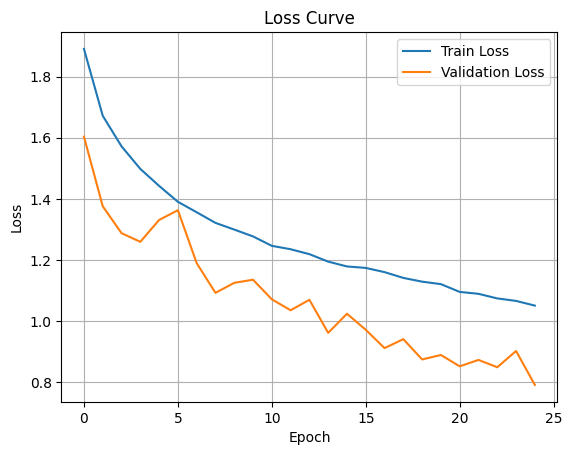

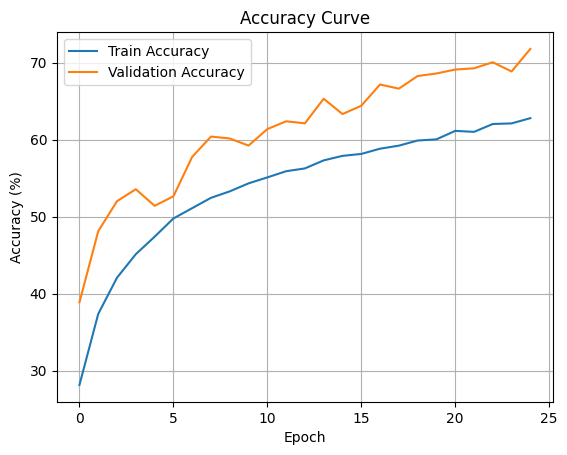

In [89]:
# Set up device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Save model
model.to(device)

# Log training 
train_losses, val_losses = [], []
train_accuracies = []
val_accuracies = []

# Training and Validation Loops 
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader), 100 * correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    total = 0
    correct = 0
    loss = 0.0

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return loss / len(loader), 100 * correct / total

# Main Loop 
epochs = 25
best_acc = 0.0

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    train_loss, train_acc = train(model, trainloader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, testloader, criterion, device)


    # Log metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Accuracy: {train_acc:.2f}%")
    print(f"Val   Loss: {val_loss:.4f} | Accuracy: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("Saved best model.")

print("\nTraining Complete")

# Print Final Averages 
avg_train_loss = sum(train_losses) / len(train_losses)
avg_val_loss = sum(val_losses) / len(val_losses)
avg_train_acc = sum(train_accuracies) / len(train_accuracies)
avg_val_acc = sum(val_accuracies) / len(val_accuracies)

print("\nFinal Averages Over All Epochs")
print(f"Average Train Loss: {avg_train_loss:.4f}")
print(f"Average Train Accuracy: {avg_train_acc:.2f}%")
print(f"Average Val   Loss: {avg_val_loss:.4f}")
print(f"Average Val   Accuracy: {avg_val_acc:.2f}%")


# Plot results

# Plot Loss
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig("loss_curve.png")

# Plot Accuracy
plt.figure()
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()
plt.savefig("accuracy_curve.png")

print("Plots saved: loss_curve.png and accuracy_curve.png")


In [90]:
# ### Data loading and augmentation from test_train.py ###
# # Added Normalize with the standard CIFAR-10 statistics
# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
# ])
# transform_test = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
# ])

# # Downloading and creating the Datasets here
# train_dataset = torchvision.datasets.CIFAR10(
#     root='./data', train=True, download=True, transform=transform_train
# )
# test_dataset = torchvision.datasets.CIFAR10(
#     root='./data', train=False, download=True, transform=transform_test
# )

# # Creating DataLoaders here
# batch_size = 128
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
# ### Training utilities from test_train.py (with fixed method names) ###
# class Accumulator:
#     """For accumulating sums over n variables."""
#     def __init__(self, n):
#         self.data = [0.0] * n
#     def add(self, *args):
#         self.data = [a + float(b) for a, b in zip(self.data, args)]
#     def reset(self):
#         self.data = [0.0] * len(self.data)
#     def __getitem__(self, idx):
#         return self.data[idx]

# def accuracy(y_hat, y):
#     """Compute the number of correct predictions."""
#     if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
#         y_hat = y_hat.argmax(axis=1)
#     cmp = (y_hat.type(y.dtype) == y)
#     return float(torch.sum(cmp))

# def evaluate_accuracy(net, data_iter, device): 
#     """Compute the accuracy for a model on a dataset."""
#     net.eval()
#     metric = Accumulator(2)  # No. of correct predictions, no. of predictions
#     with torch.no_grad():
#         for X, y in data_iter:
#             X, y = X.to(device), y.to(device)
#             metric.add(accuracy(net(X), y), y.numel())
#     return metric[0] / metric[1]

# def train_epoch(net, train_iter, loss, optimizer, device):
#     """Training function for one epoch."""
#     net.train()
#     metric = Accumulator(3)  # train_loss, train_acc, num_examples
#     for X, y in train_iter:
#         X, y = X.to(device), y.to(device)
#         optimizer.zero_grad()
#         y_hat = net(X)
#         l = loss(y_hat, y)
#         l.backward()
#         optimizer.step()
#         metric.add(float(l) * len(y), accuracy(y_hat, y), y.numel())
#     return metric[0] / metric[2], metric[1] / metric[2]

# def train_model(net, train_iter, test_iter, loss, optimizer, num_epochs, device):
#     """Train and evaluate a model."""
#     print('-' * 50)
#     print('Starting training...')
    
#     train_losses = []
#     train_accs = []
#     test_accs = []
    
#     for epoch in range(num_epochs):
#         train_metrics = train_epoch(net, train_iter, loss, optimizer, device)
#         test_acc = evaluate_accuracy(net, test_iter, device)
#         train_loss, train_acc = train_metrics
        
#         train_losses.append(train_loss)
#         train_accs.append(train_acc)
#         test_accs.append(test_acc)
        
#         print(f'Epoch {epoch + 1}:')
#         print(f'  Train loss: {train_loss:.3f}')
#         print(f'  Train accuracy: {train_acc:.3f} ({train_acc*100:.1f}%)')
#         print(f'  Test accuracy:  {test_acc:.3f} ({test_acc*100:.1f}%)')
    
#     # Plot metrics
#     plt.figure(figsize=(12, 4))
#     plt.subplot(1, 2, 1)
#     plt.plot(train_losses, label='train loss')
#     plt.xlabel('epoch')
#     plt.ylabel('loss')
#     plt.legend()
    
#     plt.subplot(1, 2, 2)
#     plt.plot([x*100 for x in train_accs], label='train acc (%)')
#     plt.plot([x*100 for x in test_accs], label='test acc (%)')
#     plt.xlabel('epoch')
#     plt.ylabel('accuracy (%)')
#     plt.legend()
#     plt.savefig('training_results.png')
#     plt.show()
    
#     return train_losses, train_accs, test_accs

# ### Main execution block ###
# if __name__ == '__main__':
#     # Device configuration
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     if device.type == 'cuda':
#         print('GPU training enabled')  # Simplified device info
    
#     # Create your model from mymodel.py
#     model = Model(
#         stem_channels=128,
#         hidden_channels=128,
#         num_blocks=3,
#         k=4,
#         r=4,
#         num_classes=10,
#         use_mlp=True
#     ).to(device)
    
#     # Define loss function and optimizer
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=0.001)
    
#     # Train the model
#     train_losses, train_accs, test_accs = train_model(
#         model, train_loader, test_loader, criterion, optimizer, num_epochs=25, device=device
#     )
    
#     # Save model
#     torch.save(model.state_dict(), "best_model.pth")
#     print("Model saved as best_model.pth")
    
#     # Print final metrics
#     print("\nFinal Metrics:")
#     print(f"Final train loss: {train_losses[-1]:.4f}")
#     print(f"Final train accuracy: {train_accs[-1]*100:.2f}%")
#     print(f"Final test accuracy: {test_accs[-1]*100:.2f}%")

Averages:


*   Train Loss: 1.7223, Accuracy: 38.21%, Validation Loss: 1.7194, Accuracy: 38.25%
*   Train Loss: 1.7106, Accuracy: 34.80%, Validation Loss: 1.7984, Accuracy: 35.98%

*   Train Loss: 1.8150, Accuracy: 34.54%, Val   Loss: 1.7848 Accuracy: 36.13%

*   Train Loss: 1.9579, Accuracy: 28.84%, Val   Loss: 1.8691, Accuracy: 32.51%
*   Train Loss: 1.9712, Accuracy: 27.54%, Val   Loss: 1.9107 ,Accuracy: 30.24%
*   Train Loss: 2.1609, Accuracy: 16.97%, Val   Loss: 2.1343, Accuracy: 18.28%
*   Train Loss: 1.9798, Accuracy: 27.24%, Val   Loss: 1.9312, Accuracy: 29.65%
*   Train Loss: 1.4970, Accuracy: 44.11%, Val   Loss: 1.3675, Accuracy: 48.65%
*   Train Loss: 1.3648, Accuracy: 51.66%, Val   Loss: 1.2319, Val   Accuracy: 55.56%
*   Train Loss: 0.7390, Accuracy: 74.50%, Val   Loss: 0.8193, Val   Accuracy: 72.47%
*  Train Loss: 0.7262, Accuracy: 74.99%, Val   Loss: 0.8539, Accuracy: 71.57%
*   Train Loss: 0.6575, Accuracy: 76.88%, Val   Loss: 0.7876, Accuracy: 73.31%
*   Train Loss: 0.6564, Accuracy: 76.91%, Val   Loss: 0.7731, Accuracy: 73.89%
*   Train Loss: 0.6747, Accuracy: 76.24%, Val   Loss: 0.7645, Accuracy: 73.83%
*   Train Loss: 0.7119, Accuracy: 74.75%, Val   Loss: 0.8092, Accuracy: 72.01%
* Train Loss: 1.0820, Accuracy: 61.24%,  Val   Loss: 0.9241, Accuracy: 66.86%
* Train Accuracy: 62.14%, Val   Loss: 0.8826, Accuracy: 68.16%
* Train Loss: 1.1482, Accuracy: 59.56%, Val   Loss: 0.9446, Accuracy: 66.12%
* Train Loss: 1.0876, Accuracy: 61.30%, Val   Loss: 0.9327,Accuracy: 66.59%
* Train Loss: 1.1938, Accuracy: 57.16%, Val   Loss: 1.0265, Accuracy: 62.66%
* Train Loss: 1.3364, Accuracy: 51.05%, Val   Loss: 1.1814, Accuracy: 56.93%